# Data Science
## Options pricing
#### Forecasting stock price volatility, and theoretically pricing probability based "options" contracts. Part 2

### Table of content

1. Part 1
2. Binomial formula
3. Black-scholes formula
4. Data query
   1. General nesting
   2. Chain nesting
   3. Book nesting
   
5. Parameter setting
   1. Assumptions
   2. Manual calculator
   3. Ouput proof
   
6. Automatic pricing system

7. Interpretation
   1. Conclution

8. Discussion
9. References

_Terminology: \
HV - Historical volatility\
IV - Implied volatility\
MC - Monte Carlo\
Chain - all maturities for underlying\
OPEX - particular maturity\
Book - all option prices by strike_

#### 1) Part 1 
In the first part of the work, we saw that with the cumulative product of mathematical formula that takes random parameter, can predict the uniform probability of stock ending in particular range, based on stock price historical behaviour. In Part 1 we concluded that we need many simulations to achive accurate prediction and avoid bias, but all this comes with the expensive computational power that Monte Carlo takes for each simulation.

#### 2) Binomial formula
The Binomial options pricing model approach has been widely used since it is able to handle a variety of conditions for which other models cannot easily be applied. This is largely because the BOPM is based on the description of an underlying instrument over a period of time rather than a single point. As a consequence, it is used to value American options that are exercisable at any time in a given interval as well as Bermudan options that are exercisable at specific instances of time. Being relatively simple, the model is readily implementable in computer software (including a spreadsheet).

Although computationally slower than the Black–Scholes formula, it is more accurate, particularly for longer-dated options on securities with dividend payments. For these reasons, various versions of the binomial model are widely used by practitioners in the options markets.

For options with several sources of uncertainty (e.g., real options) and for options with complicated features (e.g., Asian options), binomial methods are less practical due to several difficulties, and Monte Carlo option models are commonly used instead. When simulating a small number of time steps Monte Carlo simulation will be more computationally time-consuming than BOPM (cf. Monte Carlo methods in finance). However, the worst-case runtime of BOPM will be O(2n), where n is the number of time steps in the simulation. Monte Carlo simulations will generally have a polynomial time complexity, and will be faster for large numbers of simulation steps. Monte Carlo simulations are also less susceptible to sampling errors, since binomial techniques use discrete time units. This becomes more true the smaller the discrete units become. 

**Binomial formula:**

Mean: 
$P_m = P_c * e^{(GR*t)}$\
Upper band:
$P_u = P_c * e^{(GR*t + 1*StDev*\sqrt t)}$\
Lower band:
$P_l = P_c * e^{(GR*t - 1*StDev*\sqrt t)}$

Where:\
**GR** - geometric return = $(P_{end}/P_{start})^{(1/N)} -1$\
**N** - intervals lenght \
**t** - # of periods\
**StDev** - historical standard deviation (HV) of log returns, can be used with (IV)\
$\sqrt N$ - sqrt of time


Example:\
$300 * e^{(0.000433*21)} = 302.80$ or 0.93% expected mean (drift)\
$300 * e^{(0.000433*21 + 1*0.01*\sqrt 21)} = 316.94$ or +5.7%\
$300 * e^{(0.000433*21 - 1*0.01*\sqrt 21)} = 289.18$ or -3.6%

In [1]:
# !pip install yfinance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from statistics import stdev
from math import log, sqrt, exp
import requests

from datetime import datetime, date
from pandas.tseries.offsets import BDay
from scipy.stats import norm

%matplotlib inline
%precision 4
plt.style.use('classic')

In [2]:
## Get data
ticker = yf.Ticker('SPY')
data = ticker.history(period="max")
data.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-08-18,442.959991,444.630005,438.920013,439.179993,88807700,0.0,0
2021-08-19,436.269989,441.140015,436.119995,438.691498,60729027,0.0,0


In [3]:
## Parameters
geo_ret = (data.Close[-1] / data.Close[0])**(1/len(data.Close)) -1
stdev_norm = stdev(data.Close.pct_change()[1:])
stdev_log = stdev((np.log(data.Close) - np.log(data.Close.shift(1)))[1:])
sigma = 3  # 99.7% confidence interval
n = 21

In [4]:
print('Geometric return: ',geo_ret)
print('Stdev: ',stdev_norm)
print('Stdev(log): ',stdev_log) 

Geometric return:  0.00039404742116544433
Stdev:  0.011829201853961056
Stdev(log):  0.01183860414309512


In [5]:
%%time
## Calculate limits
list_up = [data.Close[-1], ]
list_low = [data.Close[-1], ]
list_mean = [data.Close[-1], ]

for i in range(1,n+1):
    upper = data.Close[-1] * exp(geo_ret*i + (sigma*stdev_log*sqrt(i)))
    lower = data.Close[-1] * exp(geo_ret*i - (sigma*stdev_log*sqrt(i)))
    mean = data.Close[-1] * exp(geo_ret*i)
    list_up.append(upper)
    list_low.append(lower)
    list_mean.append(mean)
list_up = pd.Series(list_up)
list_low = pd.Series(list_low)
list_mean = pd.Series(list_mean)

Wall time: 998 µs


_**Binomial method wall time: 998 µs**_

       band_up        mean    band_low
0   438.691498  438.691498  438.691498
1   454.731115  438.864397  423.551309
2   461.652049  439.037365  417.530493
3   467.076830  439.210400  413.006519
4   471.728799  439.383504  409.256047
5   475.887954  439.556676  405.999080
6   479.697804  439.729916  403.092109
7   483.243548  439.903225  400.449935
8   486.580665  440.076602  398.017080
9   489.747666  440.250047  395.755033
10  492.772576  440.423561  393.635771
11  495.676538  440.597143  391.638149
12  498.475968  440.770793  389.745754
13  501.183914  440.944512  387.945537
14  503.810947  441.118299  386.226927
15  506.365778  441.292155  384.581215
16  508.855678  441.466079  383.001129
17  511.286797  441.640072  381.480520
18  513.664389  441.814133  380.014135
19  515.992983  441.988263  378.597445
20  518.276518  442.162462  377.226512
21  520.518444  442.336729  375.897885
AxesSubplot(0.125,0.1;0.775x0.8)
Wall time: 77.8 ms


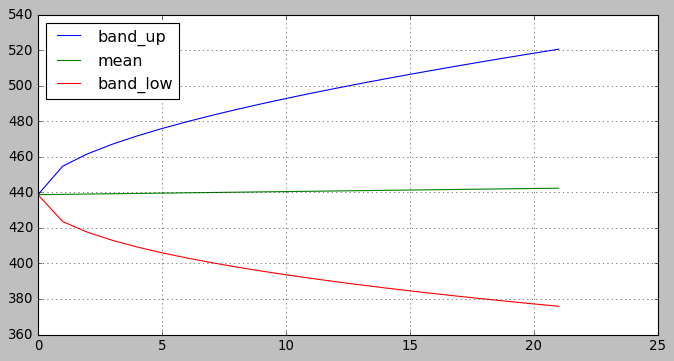

In [6]:
%%time
## Concat
bands = pd.concat([list_up, list_mean, list_low], axis=1, keys=['band_up', 'mean','band_low'])
print(bands)
print(bands.plot(figsize=(10,5)))
plt.grid()

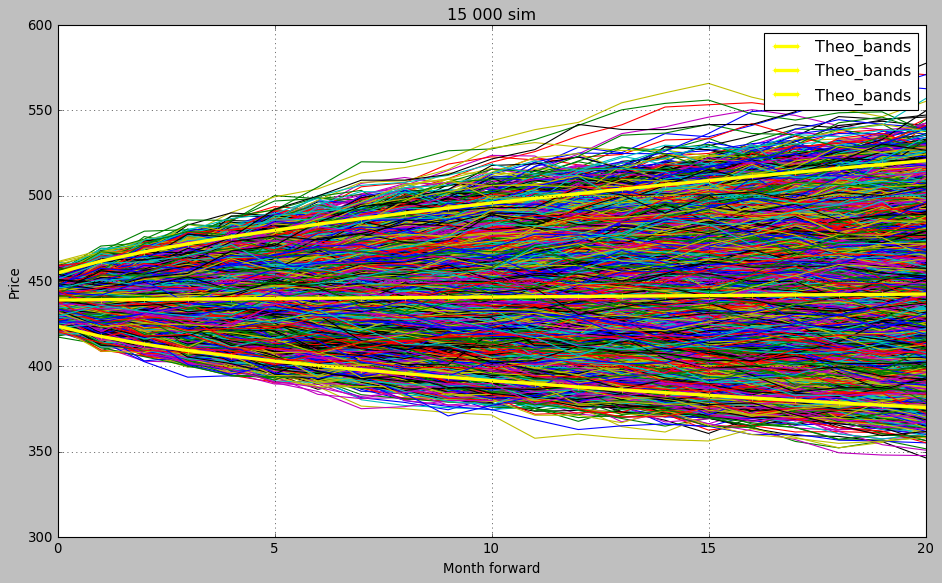

Wall time: 2min 29s


In [7]:
%%time
## Simulate 150 000
plt.figure(figsize=(14,8))
x = np.cumprod(geo_ret + (1+np.random.randn(150000,21)*stdev_log),1) * data.Close[-1]
for i in x:
    plt.plot(i)
plt.plot(bands.shift(-1), c='yellow', label='Theo_bands', 
                     linewidth=3.0, marker='+')
plt.title('15 000 sim')
plt.xlabel('Month forward')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [8]:
def hist_plot(x, n):
    '''x = hist ready array, n = # of stdev '''
    # Log transform
    end_normal = np.log(x[:,-1])
    stdev_x = stdev(end_normal)
    up_band_log = end_normal.mean() + n*stdev_x
    low_band_log = end_normal.mean() - n*stdev_x
    up_band = np.exp(up_band_log)
    low_band = np.exp(low_band_log)

    plt.figure(figsize=(14,8))
    plt.hist(x[:,-1],bins=100)
    plt.axvline(x[:,-1].mean(), color='r', label='Mean')
    plt.axvline(up_band, c='orange', label='Basic +{} sigma'.format(n))
    plt.axvline(low_band, c='orange',label='Basic -{} sigma'.format(n))
    plt.axvline(bands.band_low[-1:].tolist(), c='black',label='theo_low')
    plt.axvline(bands.band_up[-1:].tolist(), c='black',label='theo_up')

    print('Expect return/drift for MC: ', x[:,-1].mean())
    print('Expect return/drift theoretical: ', bands['mean'][-1:].tolist())
    print('Basic -{} sigma: '.format(n), low_band)
    print('Basic +{} sigma: '.format(n), up_band)
    print('Theo -{} sigma: '.format(n),bands.band_low[-1:].tolist())
    print('Theo +{} sigma: '.format(n),bands.band_up[-1:].tolist())

    plt.title('MC histogram of end values')
    plt.xlabel('Price')
    plt.ylabel('Counts')
    plt.legend()
    plt.grid()
    plt.show()

Expect return/drift for MC:  442.2614404525472
Expect return/drift theoretical:  [442.33672946172504]
Basic -3 sigma:  375.3249827095721
Basic +3 sigma:  519.6062057949449
Theo -3 sigma:  [375.8978851916734]
Theo +3 sigma:  [520.5184438085511]


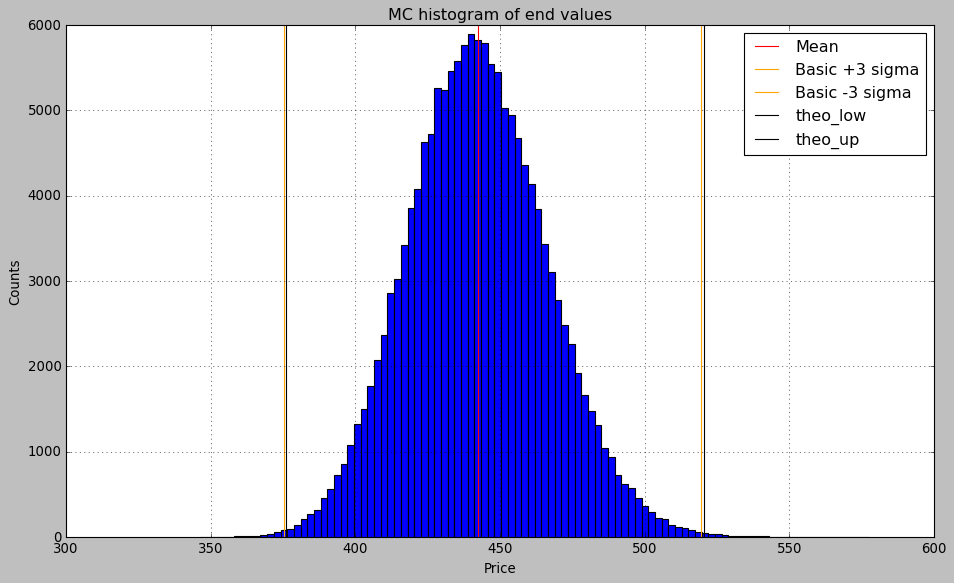

In [9]:
hist_plot(x, 3)

In [10]:
## Proof of outcome
x = pd.DataFrame(x)
end_val = x[20]
stdev_x = stdev(end_val)

theo_overshoot = end_val[end_val >= bands.band_up[21]].count()
theo_undershoot = end_val[end_val <= bands.band_low[21]].count()
theo_proof = (theo_overshoot + theo_undershoot) / end_val.count()

basic_overshoot = end_val[end_val >= (data.Close[-1] + stdev_x* 3)].count()
basic_undershoot = end_val[end_val <= (data.Close[-1] - stdev_x* 3)].count()
basic_proof = (basic_overshoot + basic_undershoot) / end_val.count()

print('Expected alpha(over/under-shoots) for 3 sigma (99.7%): ', round((100-99.7) ,4),'%')
print("Total ending values outside the bands after 150k simulations:")
print('Theoretical bands (Mathematics): ', theo_proof *100,'%')
print('Basic stdev (Monte Carlo): ', basic_proof *100,'%')  # little higher because of the drift component in simulation formula

Expected alpha(over/under-shoots) for 3 sigma (99.7%):  0.3 %
Total ending values outside the bands after 150k simulations:
Theoretical bands (Mathematics):  0.28200000000000003 %
Basic stdev (Monte Carlo):  0.4066666666666666 %


In [12]:
%%time
x = np.cumprod(geo_ret + (1+np.random.randn(150000,21)*stdev_log),1) * data.Close[-1]

Wall time: 117 ms


_**MC Simulation wall time: 117 ms**_

#### 3) Black-Scholes formula

$$\large Call = N(d_1)S_t - N(d_2)Ke^{-rt}$$\
$$\large Put = Ke^{-rt} - S_t + Call$$

_Where_:

$ d_1 = \dfrac{{ln{\frac{S_t}{K}}} + (r + {\frac{\sigma^{2}}{2}})t}{\sigma\sqrt t}$

$d_2 = d_1 - \sigma\sqrt t$


$Call$ = Call option price\
$Put$ = Put option price\
$N$ = CDF of the normal dist\
$S_t$ = spot price of the underlying asset\
$K$ = strike price\
$r$ = risk-free rate of return (10 year bonds)\
$t$ = time to matiruty\
$\sigma$ = volatility of the underlying asset

In [13]:
## Translate
def d1(S, K, t, r, sigma):
        return(log(S/K) + (r+(sigma**2)/2)*t) / (sigma*sqrt(t))
def d2(S, K, t, r, sigma):
    return d1(S, K, t, r, sigma) - sigma*(sqrt(t))

def bs_call(S, K, t, r, sigma):
    return S * norm.cdf(d1(S, K, t, r, sigma)) - norm.cdf(d2(S, K, t, r, sigma)) * K * exp(-r*t)
def bs_put(S, K, t, r, sigma):
    return K * exp(-r*t) - S + bs_call(S, K, t, r, sigma)

#### 4) Data query
We are going to get data from "Think or swim" API

In [6]:
endpoint = r"https://api.tdameritrade.com/v1/marketdata/chains"

payload = {'apikey': 'I2JOUMPTNZTOUNWXPLMXVJFJFUYH6HYQ',
           'symbol':'SPY',
           'contractType':'ALL',
           'strategy':'SINGLE',
           'range':'ALL'}

content = requests.get(url=endpoint, params=payload)
data = content.json()

#### A. General nesting

In [15]:
general = pd.DataFrame(data.items())
general = general.set_index(0)
general

,1
0,
symbol,SPY
status,SUCCESS
underlying,None
strategy,SINGLE
interval,0
isDelayed,True
isIndex,False
interestRate,0.1
underlyingPrice,438.555


#### B. Chain nesting

In [16]:
call_dict_data = general.loc['callExpDateMap'][1]
put_dict_data = general.loc['putExpDateMap'][1]

call_opex = pd.DataFrame.from_dict(call_dict_data)
put_opex = pd.DataFrame.from_dict(put_dict_data)  # yyyy-mm-dd:DTE

In [17]:
call_opex.head()

,2021-08-20:1,2021-08-23:4,2021-08-25:6,2021-08-27:8,2021-08-30:11,2021-09-01:13,2021-09-03:15,2021-09-07:19,2021-09-08:20,2021-09-10:22,...,2022-03-18:211,2022-03-31:224,2022-06-17:302,2022-06-30:315,2022-09-16:393,2022-12-16:484,2023-01-20:519,2023-03-17:575,2023-06-16:666,2023-12-15:848
190.0,"[{'putCall': 'CALL', 'symbol': 'SPY_082021C190...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[{'putCall': 'CALL', 'symbol': 'SPY_031822C190...",NaN,"[{'putCall': 'CALL', 'symbol': 'SPY_061722C190...",NaN,"[{'putCall': 'CALL', 'symbol': 'SPY_091622C190...","[{'putCall': 'CALL', 'symbol': 'SPY_121622C190...","[{'putCall': 'CALL', 'symbol': 'SPY_012023C190...","[{'putCall': 'CALL', 'symbol': 'SPY_031723C190...","[{'putCall': 'CALL', 'symbol': 'SPY_061623C190...","[{'putCall': 'CALL', 'symbol': 'SPY_121523C190..."
195.0,"[{'putCall': 'CALL', 'symbol': 'SPY_082021C195...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[{'putCall': 'CALL', 'symbol': 'SPY_031822C195...",NaN,"[{'putCall': 'CALL', 'symbol': 'SPY_061722C195...",NaN,"[{'putCall': 'CALL', 'symbol': 'SPY_091622C195...","[{'putCall': 'CALL', 'symbol': 'SPY_121622C195...","[{'putCall': 'CALL', 'symbol': 'SPY_012023C195...","[{'putCall': 'CALL', 'symbol': 'SPY_031723C195...",NaN,"[{'putCall': 'CALL', 'symbol': 'SPY_121523C195..."
200.0,"[{'putCall': 'CALL', 'symbol': 'SPY_082021C200...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[{'putCall': 'CALL', 'symbol': 'SPY_031822C200...",NaN,"[{'putCall': 'CALL', 'symbol': 'SPY_061722C200...",NaN,"[{'putCall': 'CALL', 'symbol': 'SPY_091622C200...","[{'putCall': 'CALL', 'symbol': 'SPY_121622C200...","[{'putCall': 'CALL', 'symbol': 'SPY_012023C200...","[{'putCall': 'CALL', 'symbol': 'SPY_031723C200...","[{'putCall': 'CALL', 'symbol': 'SPY_061623C200...","[{'putCall': 'CALL', 'symbol': 'SPY_121523C200..."
205.0,"[{'putCall': 'CALL', 'symbol': 'SPY_082021C205...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[{'putCall': 'CALL', 'symbol': 'SPY_031822C205...",NaN,"[{'putCall': 'CALL', 'symbol': 'SPY_061722C205...",NaN,"[{'putCall': 'CALL', 'symbol': 'SPY_091622C205...","[{'putCall': 'CALL', 'symbol': 'SPY_121622C205...","[{'putCall': 'CALL', 'symbol': 'SPY_012023C205...","[{'putCall': 'CALL', 'symbol': 'SPY_031723C205...",NaN,"[{'putCall': 'CALL', 'symbol': 'SPY_121523C205..."
210.0,"[{'putCall': 'CALL', 'symbol': 'SPY_082021C210...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[{'putCall': 'CALL', 'symbol': 'SPY_031822C210...",NaN,"[{'putCall': 'CALL', 'symbol': 'SPY_061722C210...",NaN,"[{'putCall': 'CALL', 'symbol': 'SPY_091622C210...","[{'putCall': 'CALL', 'symbol': 'SPY_121622C210...","[{'putCall': 'CALL', 'symbol': 'SPY_012023C210...","[{'putCall': 'CALL', 'symbol': 'SPY_031723C210...","[{'putCall': 'CALL', 'symbol': 'SPY_061623C210...","[{'putCall': 'CALL', 'symbol': 'SPY_121523C210..."


#### C. Book nesting

In [18]:
## Get strike data
strike_data = put_opex['2021-09-08:20']
pd.DataFrame(strike_data).dropna().head()  # dict nested in list

,2021-09-08:20
310.0,"[{'putCall': 'PUT', 'symbol': 'SPY_090821P310'..."
315.0,"[{'putCall': 'PUT', 'symbol': 'SPY_090821P315'..."
320.0,"[{'putCall': 'PUT', 'symbol': 'SPY_090821P320'..."
325.0,"[{'putCall': 'PUT', 'symbol': 'SPY_090821P325'..."
330.0,"[{'putCall': 'PUT', 'symbol': 'SPY_090821P330'..."


In [19]:
## Remove list
list_test = []
for i in range(len(strike_data)):
    x = pd.Series(strike_data[i])
    list_test.append(x)
list_test = pd.DataFrame(list_test).dropna()

In [20]:
## Append dict
a = []
for i in list(list_test.index):
    a.append(list_test[0][i])
opex_put = pd.DataFrame(a)

In [21]:
opex_put.head()

,putCall,symbol,description,exchangeName,bid,ask,last,mark,bidSize,askSize,...,multiplier,settlementType,deliverableNote,isIndexOption,percentChange,markChange,markPercentChange,nonStandard,inTheMoney,mini
0,PUT,SPY_090821P310,SPY Sep 8 2021 310 Put (Weekly),OPR,0.12,0.13,0.12,0.13,5177,1650,...,100.0,,,None,14.29,0.02,19.05,False,False,False
1,PUT,SPY_090821P315,SPY Sep 8 2021 315 Put (Weekly),OPR,0.14,0.15,0.13,0.15,616,3463,...,100.0,,,None,13.04,0.03,26.09,False,False,False
2,PUT,SPY_090821P320,SPY Sep 8 2021 320 Put (Weekly),OPR,0.15,0.16,0.14,0.16,5439,190,...,100.0,,,None,12.00,0.03,24.00,False,False,False
3,PUT,SPY_090821P325,SPY Sep 8 2021 325 Put (Weekly),OPR,0.17,0.18,0.08,0.18,4540,1268,...,100.0,,,None,-44.83,0.03,20.69,False,False,False
4,PUT,SPY_090821P330,SPY Sep 8 2021 330 Put (Weekly),OPR,0.19,0.20,0.18,0.20,4841,133,...,100.0,,,None,9.09,0.03,18.18,False,False,False


In [22]:
opex_put.columns

Index(['putCall', 'symbol', 'description', 'exchangeName', 'bid', 'ask',
       'last', 'mark', 'bidSize', 'askSize', 'bidAskSize', 'lastSize',
       'highPrice', 'lowPrice', 'openPrice', 'closePrice', 'totalVolume',
       'tradeDate', 'tradeTimeInLong', 'quoteTimeInLong', 'netChange',
       'volatility', 'delta', 'gamma', 'theta', 'vega', 'rho', 'openInterest',
       'timeValue', 'theoreticalOptionValue', 'theoreticalVolatility',
       'optionDeliverablesList', 'strikePrice', 'expirationDate',
       'daysToExpiration', 'expirationType', 'lastTradingDay', 'multiplier',
       'settlementType', 'deliverableNote', 'isIndexOption', 'percentChange',
       'markChange', 'markPercentChange', 'nonStandard', 'inTheMoney', 'mini'],
      dtype='object')

In [23]:
filter_opex = pd.DataFrame(a, columns=['putCall','symbol','daysToExpiration','expirationDate','strikePrice','theoreticalOptionValue','mark'])
filter_opex = filter_opex.sort_values(by=['strikePrice'])
filter_opex = filter_opex.reset_index(drop=True)
filter_opex.head()

,putCall,symbol,daysToExpiration,expirationDate,strikePrice,theoreticalOptionValue,mark
0,PUT,SPY_090821P310,20,1631131200000,310.0,0.125,0.13
1,PUT,SPY_090821P315,20,1631131200000,315.0,0.145,0.15
2,PUT,SPY_090821P320,20,1631131200000,320.0,0.155,0.16
3,PUT,SPY_090821P325,20,1631131200000,325.0,0.175,0.18
4,PUT,SPY_090821P330,20,1631131200000,330.0,0.195,0.20


#### 5) Parameter setting
#### A. Assumptions
Parameters:\
252 business days / year, 21 day Historical volatility, stdev of log returns, 10y treasury rates (risk free), stock is trading only business days

In [24]:
# Parameters
# expiry = datetime.fromtimestamp(int(str(filter_opex.expirationDate[0])[:-3])).strftime('%m-%d-%Y')
today = datetime.now()
start = today - BDay(21)
ticker = yf.Ticker('SPY')
df = ticker.history(ticker, start=start, end=today)

df['log_returns'] = (np.log(df.Close) - np.log(df.Close.shift(1)))
df = df.dropna()
sigma = df['log_returns'].std() * np.sqrt(252)

rf_rate = (yf.Ticker('^TNX').history(
    start=today.replace(day=today.day-1), end=today)['Close'].iloc[-1])/100

close = df['Close'].iloc[-1]

time_delta = filter_opex.daysToExpiration[0] / 252

#### B. Manual calculator

In [25]:
%%time
## Get call prices
strikes = filter_opex.strikePrice
book_prices = []
for i in range(len(strikes)):
    c = bs_call(close, strikes[i], time_delta, rf_rate, sigma)
    p = bs_put(close, strikes[i], time_delta, rf_rate, sigma)
    book_prices.append({'call':c, 'put':p, 'strike':strikes[i]})

Wall time: 51.9 ms


In [26]:
book_prices = pd.DataFrame(book_prices)
book_prices

,call,put,strike
0,1.287965e+02,0.000000,310.0
1,1.238015e+02,0.000000,315.0
2,1.188064e+02,0.000000,320.0
3,1.138113e+02,0.000000,325.0
4,1.088162e+02,0.000000,330.0
...,...,...,...
109,7.601329e-08,56.021489,495.0
110,5.396904e-09,61.016571,500.0
111,1.679646e-11,71.006734,510.0
112,2.822654e-14,80.996898,520.0


In [27]:
filter_opex['theo_call'] = book_prices.call
filter_opex['theo_put'] = book_prices.put

In [28]:
filter_opex.head()

,putCall,symbol,daysToExpiration,expirationDate,strikePrice,theoreticalOptionValue,mark,theo_call,theo_put
0,PUT,SPY_090821P310,20,1631131200000,310.0,0.125,0.13,128.796537,0.0
1,PUT,SPY_090821P315,20,1631131200000,315.0,0.145,0.15,123.801455,0.0
2,PUT,SPY_090821P320,20,1631131200000,320.0,0.155,0.16,118.806373,0.0
3,PUT,SPY_090821P325,20,1631131200000,325.0,0.175,0.18,113.811292,0.0
4,PUT,SPY_090821P330,20,1631131200000,330.0,0.195,0.20,108.816210,0.0


#### C. Output proof
Think or swim have build in options pricing, it uses average of book Implied volatility as parameter in the calculation.\
If market is trading higher than predicted then we have variance risk premium and inflated options prices.

In [29]:
compare = filter_opex[(filter_opex['theoreticalOptionValue'] > 0)&(filter_opex['theo_put'] > 0)]
print('Avg.$ difference: ')
print('Compare with provider benchmark: ', np.mean(filter_opex.theoreticalOptionValue - filter_opex.theo_put))
print('Compare with last traded price: ', np.mean(filter_opex.mark - filter_opex.theo_put))

Avg.$ difference: 
Compare with provider benchmark:  1.3372847800213201
Compare with last traded price:  1.3494602186178113


In [30]:
filter_opex

,putCall,symbol,daysToExpiration,expirationDate,strikePrice,theoreticalOptionValue,mark,theo_call,theo_put
0,PUT,SPY_090821P310,20,1631131200000,310.0,0.125,0.13,1.287965e+02,0.000000
1,PUT,SPY_090821P315,20,1631131200000,315.0,0.145,0.15,1.238015e+02,0.000000
2,PUT,SPY_090821P320,20,1631131200000,320.0,0.155,0.16,1.188064e+02,0.000000
3,PUT,SPY_090821P325,20,1631131200000,325.0,0.175,0.18,1.138113e+02,0.000000
4,PUT,SPY_090821P330,20,1631131200000,330.0,0.195,0.20,1.088162e+02,0.000000
...,...,...,...,...,...,...,...,...,...
109,PUT,SPY_090821P495,20,1631131200000,495.0,56.440,56.42,7.601329e-08,56.021489
110,PUT,SPY_090821P500,20,1631131200000,500.0,61.440,61.32,5.396904e-09,61.016571
111,PUT,SPY_090821P510,20,1631131200000,510.0,71.440,71.44,1.679646e-11,71.006734
112,PUT,SPY_090821P520,20,1631131200000,520.0,81.440,81.44,2.822654e-14,80.996898


#### 6. Automatic pricing system
In order to keep with the every second that underlying changes we need short interval updates and universal function that will calculate and ouput fair prices of each contract.\
Start from filter_opex matrix because it have to be updated once a day before the trading session.

In [31]:
def auto_pricing(ticker, hv_days, filter_opex):
    '''Options pricing system with live feed data.
    '''
    # Parameters
    expiry = datetime.fromtimestamp(int(str(filter_opex.expirationDate[0])[:-3])).strftime('%m-%d-%Y')
    today = datetime.now()
    start = today - BDay(hv_days)
    ticker = yf.Ticker('SPY')
    df = ticker.history(ticker, start=start, end=today)
    close = df['Close'].iloc[-1]
    
    df['log_returns'] = (np.log(df.Close) - np.log(df.Close.shift(1)))
    df = df.dropna()
    sigma = df['log_returns'].std() * np.sqrt(252)

    rf_rate = (yf.Ticker('^TNX').history(
        start=today.replace(day=today.day-1), end=today)['Close'].iloc[-1])/100

    time_delta = filter_opex.daysToExpiration[0] / 252
    
    ## Get call prices
    strikes = filter_opex.strikePrice
    book_prices = []
    for i in range(len(strikes)):
        c = bs_call(close, strikes[i], time_delta, rf_rate, sigma)
        p = bs_put(close, strikes[i], time_delta, rf_rate, sigma)
        book_prices.append({'call':c, 'put':p, 'strike':strikes[i]})
    book_prices = pd.DataFrame(book_prices)
    
    return book_prices

In [32]:
%%time
auto_pricing('SPY', 21, filter_opex)

Wall time: 418 ms


,call,put,strike
0,1.287965e+02,0.000000,310.0
1,1.238015e+02,0.000000,315.0
2,1.188064e+02,0.000000,320.0
3,1.138113e+02,0.000000,325.0
4,1.088162e+02,0.000000,330.0
...,...,...,...
109,7.601329e-08,56.021489,495.0
110,5.396904e-09,61.016571,500.0
111,1.679646e-11,71.006734,510.0
112,2.822654e-14,80.996898,520.0


### 7. Interpretation

The proposed method takes less time to compute single financial contract, thus whole option chain takes less than second and can be used to make markets on bigger scale. \
The proofing is done with already created benchmark by the API provider and with last traded price for each contract and the average error is indicating current options prices.

### 8. Discussion

Improvment with the greeks - "theta" decay if making intraday short term contracts market. \
Automatic systems cannot operate on Jupyter Notebooks, must transfer the code to IDE and integrate automated quote placement function that will operate with the API.\
Make sure to check other financial models for pricing options that does not assume voaltility is constant.\
The project successfuly predicts the anticipated future volatility based only on historical. The formula eliminates the computation expense that Monte Carlo have and now it can be used for lot of realtime markets at the same time.\
Current readings are higher than anticipated because the market recently declined and that automatically inflates the contract prices because people seek protection.\
Binomial bands for 21 periods ahead are calculated for 998 µs while Monte Carlo takes 117 ms, speed is crucial because every second underlying is changing so do the options probabilities.

### 9. References

 - https://en.wikipedia.org/wiki/Binomial_options_pricing_model
 - https://www.investopedia.com/terms/b/binomialoptionpricing.asp
 - https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model
 - https://www.tdameritrade.com/tools-and-platforms/thinkorswim.html
 - https://developer.tdameritrade.com/apis (God bless the free stuff)